# Further Hypothesis Testing

In [1]:
# Select this cell and type Ctrl-Enter to execute the code below.

library(tidyverse)

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width = width_choice, repr.plot.height = height_choice)
}

cbPal <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#CC79A7", "#0072B2", "#D55E00")

set_plot_dimensions(5, 4)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
# You should see "Attaching packages" and some ticks by the packages loaded.
# The "Conflicts" aren't a problem.

# Other problems loading the library? Try running this cell.

install.packages("tidyverse")

library(tidyverse)


## 6 - Testing for normality

In [2]:
# Run this cell to load the data.

data <- read_csv("../assets/stars.csv")

type_key <- c("Brown Dwarf", "Red Dwarf", "White Dwarf", "Main Sequence", "Supergiant", "Hypergiant")
spectral_classes <- c("O", "B", "A", "F", "G", "K", "M")

data$type <- factor(data$type)
data$spectral_class <- factor(data$spectral_class, levels = spectral_classes)


Rows: 240 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_class
dbl (4): temperature, luminosity, radius, type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Professor Xu thinks that the current system for classifying stars can be improved. In particular, she thinks that log(temperature) should be normally distributed for each star type. 

She has asked you to find out whether this is true under the current classification system, and if not, which types should be revised.

### Question: for which star types is log(temperature) normally distributed?

### Q-Q plot

#### Theory

We can use a Q-Q plot to investigate whether each sample resembles a normal distribution.

If we set

$x =$ the theoretical quantiles from the standard normal ($Z$) distribution, and

$y =$ the quantiles from the sample,

the Q-Q plot will be close to a straight line for samples that are approximately normally distributed.

Although this is not a rigorous statistical method, it can be enough to suggest whether a normal approximation is likely to be valid for a particular data set, or to diagnose [*skewness*](https://en.wikipedia.org/wiki/Skewness) and/or [*kurtosis*](https://en.wikipedia.org/wiki/Kurtosis) :

In [4]:
do_plots <- function(sample, col = "gray", lab = "", mu = "none", sigma = "none") {
    set_plot_dimensions(8, 4)
    par(mfrow = c(1, 2))

    # histogram
    nbins <- 20
    smin <- min(sample)
    smax <- max(sample)
    binwidth <- (smax - smin) / nbins
    bins <- seq(smin, smax, binwidth)
    hist(sample,
        breaks = bins, xlim = c(smin, smax),
        xlab = "observed", ylab = "freq", col = col, main = lab
    )


    if (mu != "none") {
        n <- length(sample)
        lines(bins, n * binwidth * dnorm(bins, mean = mu, sd = sigma), type = "l", col = "black")
    }

    # Q-Q plot

    x <- seq(0, 1, 0.01)
    normal_q <- qnorm(x)
    sample_q <- quantile(sample, x)

    xlab <- "standard normal"
    ylab <- "observed"

    # the plot itself:
    plot(normal_q, sample_q, col = col, xlab = xlab, ylab = ylab, main = lab)

    # the line passing through Q25 and Q75:
    m <- (sample_q[75] - sample_q[25]) / (normal_q[75] - normal_q[25])
    c <- sample_q[25] - normal_q[25] * m
    lines(normal_q, m * normal_q + c, type = "l", col = "black")
}


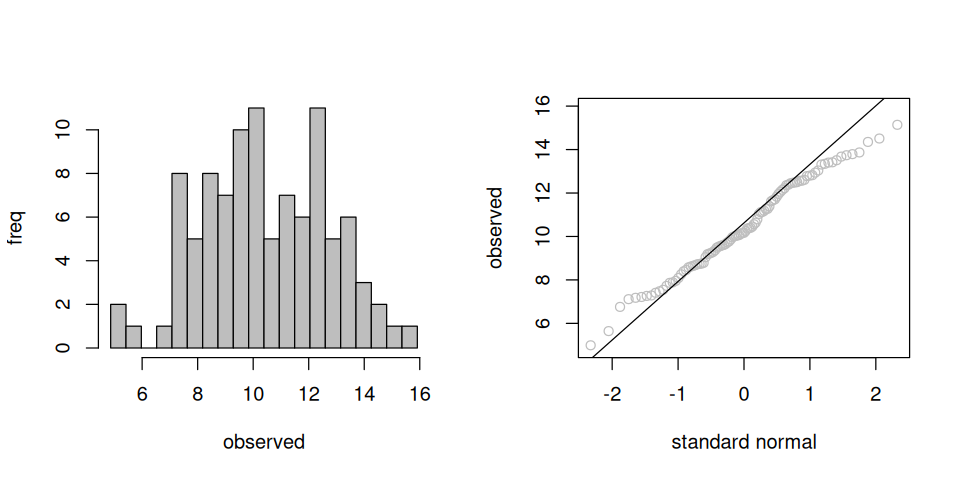

In [7]:
### normally distributed data
sample <- rnorm(mean = 10, sd = 2, n = 100)

do_plots(sample)


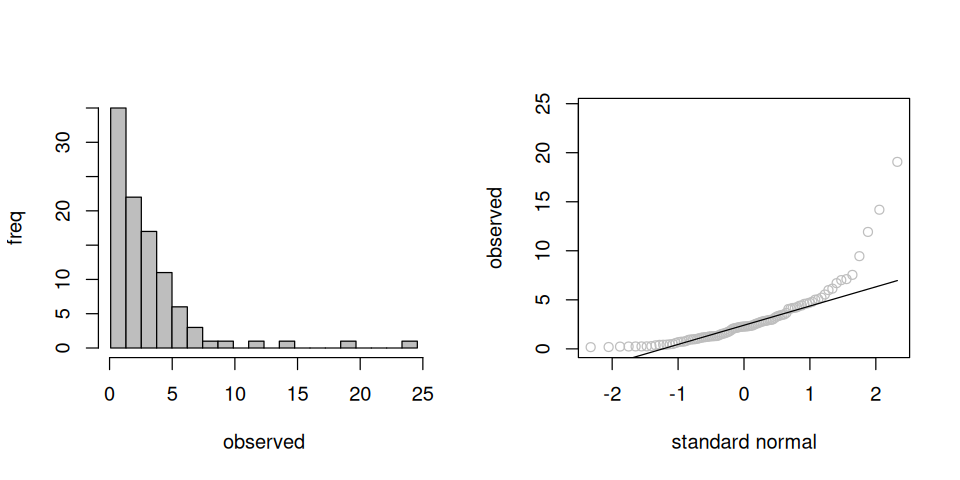

In [8]:
### positively skewed data (e.g. lognormal): pdf dragged to positive, Q-Q plot convex w.r.t. standard normal
sample <- rlnorm(meanlog = 0.5, n = 100)

do_plots(sample)


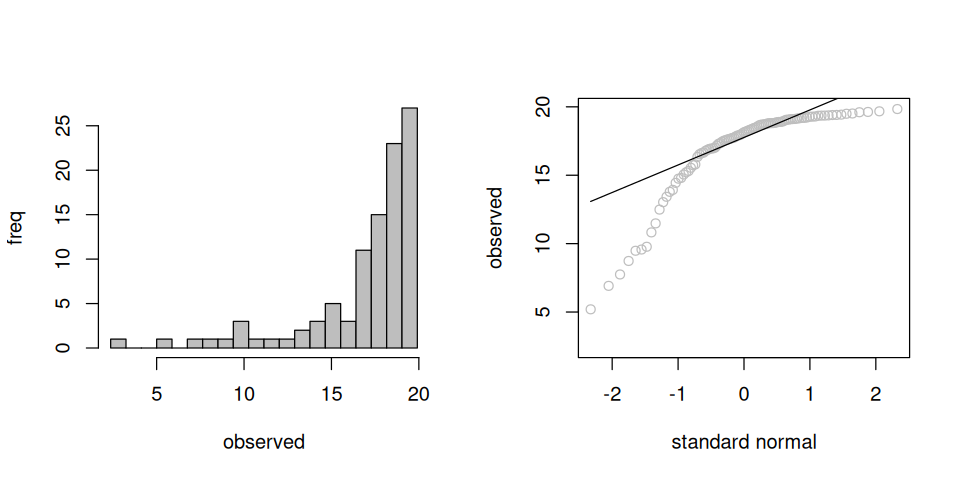

In [13]:
### negatively skewed data (e.g. constant - lognormal): pdf dragged to negative, Q-Q plot concave w.r.t. standard normal
sample <- 20 - rlnorm(meanlog = 0.5, n = 100)

do_plots(sample)


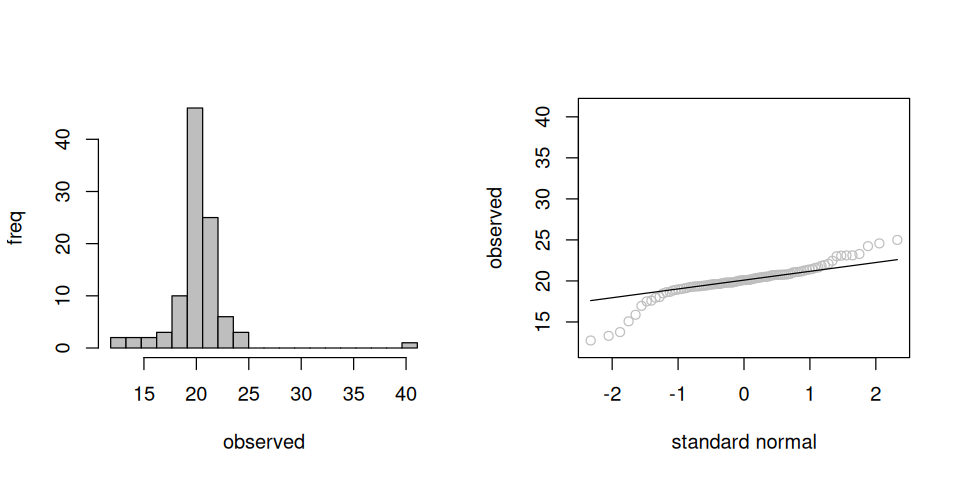

In [11]:
### leptokurtic (heavy-tailed) data (e.g. Student's t-distribution with df=2)
sample <- 20 + rt(df = 2, n = 100)

do_plots(sample)


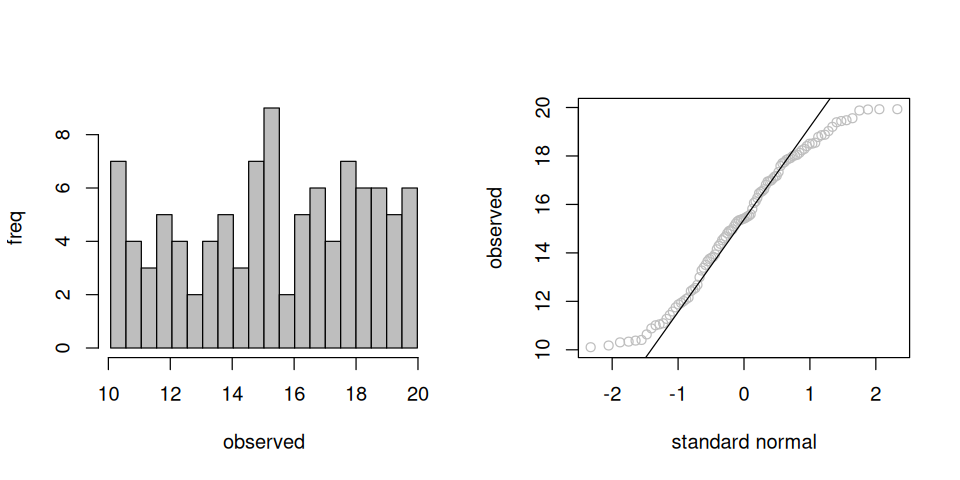

In [12]:
### platykurtic (thin-tailed) data (e.g. uniform distribution)
sample <- runif(min = 10, max = 20, n = 100)

do_plots(sample)


It can also be a useful way to identify the data points that are responsible for any deviations from normality.

#### Application

Run the code below to see the histograms and Q-Q plots for log(temperature) for each star type:

[1] "Brown Dwarf"
[1] "mean: 7.99934325832345    SD: 0.116067269853234"


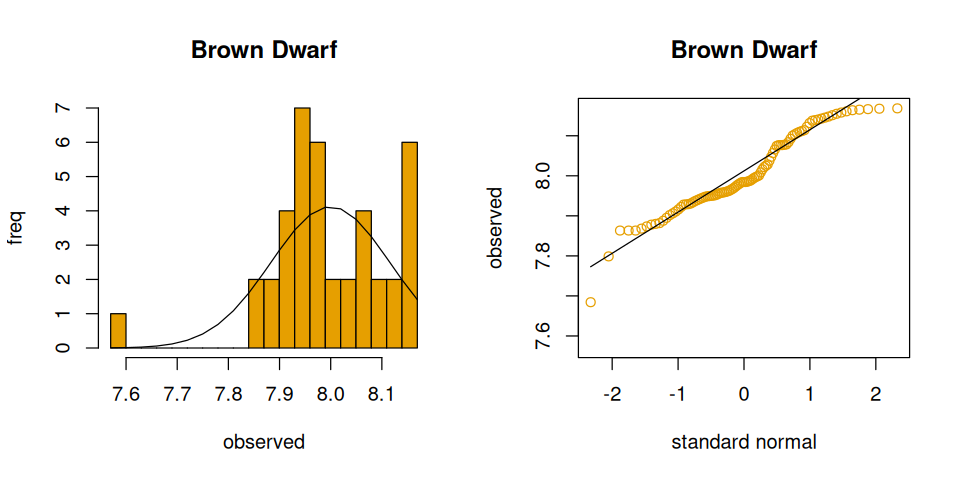

In [14]:
### Set the star type to test
t <- 0

sample <- data %>%
    filter(type == t) %>%
    pull(temperature) %>%
    log()
col <- cbPal[t + 1]
lab <- type_key[t + 1]

mu <- mean(sample)
sigma <- sd(sample)

do_plots(sample, col, lab, mu, sigma)
print(type_key[t + 1])
print(paste("mean:", mu, "   SD:", sigma))


[1] "Red Dwarf"
[1] "mean: 8.09333819153325    SD: 0.0847593525363888"


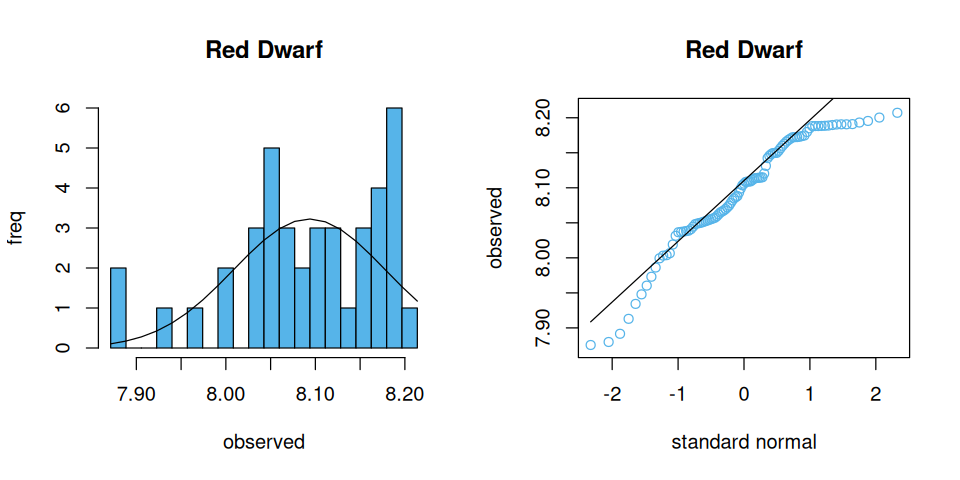

In [17]:
### Set the star type to test
t <- 1

sample <- data %>%
    filter(type == t) %>%
    pull(temperature) %>%
    log()
col <- cbPal[t + 1]
lab <- type_key[t + 1]

mu <- mean(sample)
sigma <- sd(sample)

do_plots(sample, col, lab, mu, sigma)
print(type_key[t + 1])
print(paste("mean:", mu, "   SD:", sigma))


For which of the star types does log(temperature) appear approximately normal? How would you describe the other distributions?

Of course, for a more rigorous investigation of normality, we can use a statistical test:

### Shapiro-Wilk test

#### Theory

The [*Shapiro–Wilk test*](https://en.wikipedia.org/wiki/Shapiro–Wilk_test) tests the null hypothesis that a sample $x_1, ..., x_n$ came from a normally distributed population.

It compares statistics obtained from the observed data to the expected values of statistics sampled from the standard normal distribution.

#### Application

The Shapiro-Wilk test is easy to apply in R:

In [15]:
### set the star type to test
t <- 0

sample <- data %>%
    filter(type == t) %>%
    pull(temperature) %>%
    log()

p_value <- shapiro.test(sample)$p.value

print(type_key[t + 1])
print(paste("p =", p_value))


[1] "Brown Dwarf"
[1] "p = 0.00215765989350542"


In [16]:
### set the star type to test
t <- 1

sample <- data %>%
    filter(type == t) %>%
    pull(temperature) %>%
    log()

p_value <- shapiro.test(sample)$p.value

print(type_key[t + 1])
print(paste("p =", p_value))


[1] "Red Dwarf"
[1] "p = 0.0174192730365526"


Apply the Shapiro-Wilk test to each of the star types. Which of them produce p-values less than $\alpha$ = 0.05? 

### Alternative tests for normality

Many other tests for normality have been developed, including the Anderson-Darling, Cramér–von Mises and Kolmogorov-Smirnov (see below) tests. 

The Shapiro-Wilk test has been found to have the best statistical power for a given significance level.

<br>

---